# Download Steam Banners

Code inspired from https://github.com/woctezuma/download-steam-banners

## Setting

Mount Google Drive

In [1]:
!pip install Google-Colab-Transfer

In [0]:
import colab_transfer

colab_transfer.mount_google_drive()

Install Python requirements

In [3]:
!pip install aiofiles aiohttp steamspypi

     |████████████████████████████████| 1.2MB 4.4MB/s 
     |████████████████████████████████| 256kB 53.7MB/s 
     |████████████████████████████████| 153kB 51.3MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=e9cd933c166933f9bc082dc82843f23d46418726c50b5c9ce08523675f3cf180
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


Input

In [0]:
import steamspypi

def get_app_ids_file_name():
  return 'app_ids.txt'

def create_app_id_list():
  data = steamspypi.load()
  
  with open(get_app_ids_file_name(), 'w') as f:
    for app_id in sorted(list(data.keys()), key=int):
      f.write(str(app_id) + '\n')

def get_app_ids():
    with open(get_app_ids_file_name(), 'r') as f:
      app_ids = [int(app_id.strip()) for app_id in f.readlines()]
    return app_ids

Data source

In [0]:
def get_banner_conventional_name(is_horizontal_banner=True):
  if is_horizontal_banner:
    # A choice of horizontal banners:
    # NB: originally, I used 'header' for my experiments with Steam banners.

    # banner_conventional_name = 'header' # 460x215 ; ratio 2.14
    # banner_conventional_name = 'capsule_231x87' # 231x87 ; ratio 2.66
    # banner_conventional_name = 'capsule_467x181' # 467x181 ; ratio 2.58
    banner_conventional_name = 'capsule_616x353' # 616x353 ; ratio 1.75

  else:
    # A choice of vertical banners:
    # Caveat: these may not always exist! It is a recent addition to Steam!
    
    banner_conventional_name = 'library_600x900' # 300x450 ; ratio 0.67
    # banner_conventional_name = 'library_600x900_2x' # 600x900 ; ratio 0.67

  return banner_conventional_name

In [0]:
def get_banner_url(app_id, 
                   is_horizontal_banner=True):
  return 'https://steamcdn-a.akamaihd.net/steam/apps/' + str(app_id) + '/' + get_banner_conventional_name(is_horizontal_banner) + '.jpg'  

Output

In [0]:
from pathlib import Path

def get_banner_folder(prefixe = 'original', 
                      is_horizontal_banner=True):
  if is_horizontal_banner:
    prefixe += '_horizontal'
  else:
    prefixe += '_vertical'

  banner_folder = 'data/'+prefixe+'_steam_banners/'
  Path(banner_folder).mkdir(exist_ok=True)  
  return banner_folder

def get_file_extension():
  return '.jpg'
  
def get_banner_file_name(app_id, 
                         prefixe='original',
                         is_horizontal_banner=True):
  banner_folder_name = get_banner_folder(is_horizontal_banner=is_horizontal_banner)
  banner_file_name = banner_folder_name + str(app_id) + get_file_extension()
  return banner_file_name

## Download Steam banners

**Caveat**: there are about 30,000 banners to download!

In [0]:
import asyncio
import aiofiles
import aiohttp

async def main(is_horizontal_banner=True):
    async with aiohttp.ClientSession() as session:

        for app_id in sorted(get_app_ids()):
            banner_file_name = Path(get_banner_file_name(app_id, 
                                                         is_horizontal_banner=is_horizontal_banner))

            if banner_file_name.exists():
                continue

            banner_url = get_banner_url(app_id, 
                                        is_horizontal_banner)

            # Reference: https://stackoverflow.com/a/51745925
            async with session.get(banner_url) as resp:
                if resp.status == 200:
                    f = await aiofiles.open(banner_file_name, mode='wb')
                    await f.write(await resp.read())
                    await f.close()
                    print('Banner downloaded to {} for appID {}.'.format(banner_file_name, app_id))
                else:
                    print('Banner for appID {} could not be downloaded.'.format(app_id))


In [0]:
# For horizontal banners:
is_horizontal_banner=True

# For vertical banners:
# is_horizontal_banner=False

In [0]:
create_app_id_list()

loop = asyncio.get_event_loop()
loop.run_until_complete(main(is_horizontal_banner=is_horizontal_banner))

## Post-processing appIDs

AppIDs for which a Steam banner was effectively downloaded:

In [0]:
import glob

def get_app_ids_with_steam_banners(is_horizontal_banner=True):
    image_filenames = Path(get_banner_folder(is_horizontal_banner=is_horizontal_banner)).glob('*' + get_file_extension())

    app_ids = [banner.name.strip(get_file_extension()) for banner in image_filenames]
    
    # There is an issue with duplicates, e.g. 'ABC (1).jpg' but only when running on Google Drive:
    app_ids = [app_id for app_id in app_ids if ' (' not in app_id]

    app_ids = [int(app_id) for app_id in app_ids]
    
    return app_ids

Compare the number appIDs in SteamSpy database with the number of banners saved to disk

In [0]:
create_app_id_list()     

app_ids = get_app_ids()
print('#appIDs in SteamSpy database = {}'.format(len(app_ids)))

app_ids_with_steam_banners = get_app_ids_with_steam_banners(is_horizontal_banner=is_horizontal_banner)
print('#banners saved to disk = {}'.format(len(app_ids_with_steam_banners)))

Omit appIDs for which a banner could not be found

In [0]:
def trim_app_id_list(is_horizontal_banner=True):
  app_ids = get_app_ids()
  
  app_ids_with_steam_banners = get_app_ids_with_steam_banners(is_horizontal_banner=is_horizontal_banner)
  
  common_app_ids = set(app_ids).intersection(app_ids_with_steam_banners) 
  
  with open(get_app_ids_file_name(), 'w') as f:
    for app_id in sorted(common_app_ids, key=int):
      f.write(str(app_id) + '\n')   

In [0]:
create_app_id_list()    
trim_app_id_list(is_horizontal_banner=is_horizontal_banner)     

app_ids = get_app_ids()
print('#appIDs in SteamSpy database, and with a banner saved to disk = {}'.format(len(app_ids)))

## Archive the downloaded Steam banners to Google Drive

Before applying any post-processing, we archive the downloaded Steam banners to Google Drive.

In [0]:
import colab_transfer

colab_path = colab_transfer.get_path_to_home_of_local_machine()
drive_path = colab_transfer.get_path_to_home_of_google_drive()

### Horizontal banners

In [0]:
input_file_name = 'original_horizontal_steam_banners.tar'

Save to Google Drive

In [0]:
!du -sh /content/data/original_horizontal_steam_banners/

In [0]:
!tar cvf original_horizontal_steam_banners.tar /content/data/original_horizontal_steam_banners/

In [0]:
!du -sh /content/original_horizontal_steam_banners.tar

In [0]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=colab_path,
    destination=drive_path,
)

Load from Google Drive

In [18]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=drive_path,
    destination=colab_path,
)

Copying /content/drive/My Drive/original_horizontal_steam_banners.tar to /content/original_horizontal_steam_banners.tar


In [0]:
!mkdir -p /content/data/original_horizontal_steam_banners/

In [0]:
!tar xvf original_horizontal_steam_banners.tar -C /

### Vertical banners

In [0]:
input_file_name = 'original_vertical_steam_banners.tar'

Save to Google Drive

In [0]:
!du -sh /content/data/original_vertical_steam_banners/

In [0]:
!tar cvf original_vertical_steam_banners.tar /content/data/original_vertical_steam_banners/

In [0]:
!du -sh /content/original_vertical_steam_banners.tar

In [0]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=colab_path,
    destination=drive_path,
)

Load from Google Drive

In [25]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=drive_path,
    destination=colab_path,
)

Copying /content/drive/My Drive/original_vertical_steam_banners.tar to /content/original_vertical_steam_banners.tar


In [0]:
!mkdir -p /content/data/original_vertical_steam_banners/

In [0]:
!tar xvf original_vertical_steam_banners.tar -C /

## Post-processing Steam banners



In [0]:
import os

os.chdir('/content/')

Create a folder where banners resized to square proportions will be stored

In [0]:
prefixe = 'resized'

if is_horizontal_banner:
  prefixe += '_horizontal'
else:
  prefixe += '_vertical'

Path('data/'+prefixe+'_steam_banners/').mkdir(exist_ok=True)

Function to read banner names

In [0]:
def get_banner_names(prefixe='original',
                     is_horizontal_banner=True):
  if is_horizontal_banner:
    prefixe += '_horizontal'
  else:
    prefixe += '_vertical'

  banner_names = [Path(f).name for f in glob.glob('data/'+prefixe+'_steam_banners/*.jpg')]
  return banner_names

Find banners which were downloaded but not yet resized

In [0]:
def find_new_banners(is_horizontal_banner=True):
  l_original = get_banner_names('original',
                                is_horizontal_banner=is_horizontal_banner)
  l_resized = get_banner_names('resized',
                               is_horizontal_banner=is_horizontal_banner)

  l_new = set(l_original).difference(l_resized)

  app_ids_new = [int(app_id.strip(get_file_extension())) for app_id in l_new]
  
  print('#banners downloaded but not yet resized = {}'.format(len(app_ids_new)))
  
  return app_ids_new

Handle a log file with appIDs of banners which have yet to be resized

In [0]:
def get_copy_and_resize_todo_file_name():
  return 'copy_and_resize_todo.txt'

def create_copy_and_resize_todo(is_horizontal_banner=True):
  
  app_ids_new = find_new_banners(is_horizontal_banner=is_horizontal_banner)
  
  with open(get_copy_and_resize_todo_file_name(), 'w') as f:
    for app_id in app_ids_new:
      f.write(str(app_id) + '\n')

  return

def load_copy_and_resize_todo():

  with open(get_copy_and_resize_todo_file_name(), 'r') as f:
      app_ids = [int(app_id.strip()) for app_id in f.readlines()]
  
  return app_ids

In [54]:
create_copy_and_resize_todo(is_horizontal_banner=is_horizontal_banner) 

#banners downloaded but not yet resized = 14035


Install ImageMagick

In [0]:
!apt-get install imagemagick

Resize banners from 215x460 pixels to 215x215 pixels

**Caveat: this process is extremely fast [if run locally](https://github.com/woctezuma/download-steam-banners/blob/master/batch_resize_images.py), and is extremely slow if run on the cloud!**

In [0]:
for app_id in load_copy_and_resize_todo():
  if is_horizontal_banner:
    !echo convert data/original_horizontal_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_horizontal_steam_banners/{app_id}.jpg
    !convert data/original_horizontal_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_horizontal_steam_banners/{app_id}.jpg
  else:
    !echo convert data/original_vertical_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_vertical_steam_banners/{app_id}.jpg
    !convert data/original_vertical_steam_banners/{app_id}.jpg -resize '215x215!' data/resized_vertical_steam_banners/{app_id}.jpg    


Manually check one banner

Dimensions: (450, 300, 3) for file: data/original_vertical_steam_banners/620.jpg


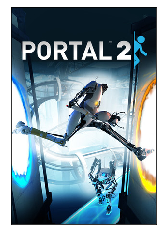

In [65]:
import cv2
from matplotlib import pyplot as plt

app_id = 620

for prefixe in ['original_horizontal', 
                'resized_horizontal',
                'original_vertical', 
                'resized_vertical']:

  img_name = 'data/' + prefixe + '_steam_banners/'+str(app_id)+'.jpg'

  img = cv2.imread(img_name)

  try:
    plt.imshow(img[..., ::-1])
  except TypeError:
    continue

  print('Dimensions: {} for file: {}'.format(img.shape,
                                             img_name))

  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

Automatically check every banner. Caveat: this is slow and optional!

In [0]:
import cv2

app_ids_to_resize = []
counters = {'original':0, 'resized':0}

for counter, app_id in enumerate(get_app_ids()):
  
  img_name = get_banner_file_name(app_id=app_id,
                      prefixe='resized',
                      is_horizontal_banner=is_horizontal_banner)

  img = cv2.imread(img_name)
  
  if img is None:
    print('Missing banner for appID = {}'.format(app_id))
    continue
  
  if img.shape[0] != img.shape[1]:    
    print('Non-square banner size for appID = {}'.format(app_id))
    app_ids_to_resize.append(app_id)
    counters['original'] += 1
  else:
    counters['resized'] += 1

  if (counter+1) % 100 == 0:
    print('Current counters: {}'.format(counters))    

Ensure that the banners which had slipped through the resize process somehow are resized.

**Caveat: this process is extremely fast [if run locally](https://github.com/woctezuma/download-steam-banners/blob/master/batch_resize_images.py), and is extremely slow if run on the cloud!**

In [0]:
for counter, app_id in enumerate(app_ids_to_resize):  
  
  img_name = get_banner_file_name(app_id=app_id,
                      prefixe='resized',
                      is_horizontal_banner=is_horizontal_banner)

  img = cv2.imread(img_name)
   
  if img.shape[0] != img.shape[1]:
    if is_horizontal_banner:
      !echo mogrify -resize '215x215!' data/resized_horizontal_steam_banners/{app_id}.jpg
      !mogrify -resize '215x215!' data/resized_horizontal_steam_banners/{app_id}.jpg
    else:
      !echo mogrify -resize '215x215!' data/resized_vertical_steam_banners/{app_id}.jpg
      !mogrify -resize '215x215!' data/resized_vertical_steam_banners/{app_id}.jpg    
  else:
    continue

  if (counter+1) % 100 == 0:
    print('{} images processed'.format(counter+1))

## Archive the resized images

At the end, archive the resized images into a .tar file, and copy it to Google Drive.

In [0]:
import colab_transfer

colab_path = colab_transfer.get_path_to_home_of_local_machine()
drive_path = colab_transfer.get_path_to_home_of_google_drive()

### Horizontal banners

In [0]:
input_file_name = 'resized_horizontal_steam_banners.tar'

Save to Google Drive

In [0]:
!du -sh /content/data/resized_horizontal_steam_banners/

In [0]:
!tar cvf resized_horizontal_steam_banners.tar /content/data/resized_horizontal_steam_banners/

In [0]:
!du -sh /content/resized_horizontal_steam_banners.tar

In [0]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=colab_path,
    destination=drive_path,
)

### Vertical banners

In [0]:
input_file_name = 'resized_vertical_steam_banners.tar'

Save to Google Drive

In [0]:
!du -sh /content/data/resized_vertical_steam_banners/

In [0]:
!tar cvf resized_vertical_steam_banners.tar /content/data/resized_vertical_steam_banners/

In [0]:
!du -sh /content/resized_vertical_steam_banners.tar

In [0]:
colab_transfer.copy_file(
    file_name=input_file_name,
    source=colab_path,
    destination=drive_path,
)